In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow_datasets as tfds

2024-11-02 12:48:40.046851: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 12:48:40.049683: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 12:48:40.084489: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 12:48:40.084512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 12:48:40.084536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
tf.config.list_physical_devices()

2024-11-01 10:41:59.613379: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
(train_set, val_set), info = tfds.load('cats_vs_dogs',
                                        split         = ['train[:80%]', 'train[80%:]'],
                                        as_supervised = True,
                                        with_info     = True)

print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/home/s2310144/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon

2024-11-02 12:48:47.179156: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
IMG_SIZE   = (224,224)
BATCH_SIZE = 256

In [4]:
def preprocess_image(image, label):
    image  = tf.image.resize(image, IMG_SIZE)
    image  = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
training_set   = train_set.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
training_set   = training_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

validation_set = val_set.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
validation_set = validation_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [6]:
val_size       = int(0.4 * len(validation_set))
test_set       = validation_set.take(val_size)
validation_set = validation_set.skip(val_size)

In [7]:
images, labels = next(iter(training_set))

image = images[0]
print(f'Image Shape: {image.shape}\nImage dtype: {image.dtype}\nMax pixel value: {np.max(image)}')

Image Shape: (224, 224, 3)
Image dtype: <dtype: 'float32'>
Max pixel value: 1.0


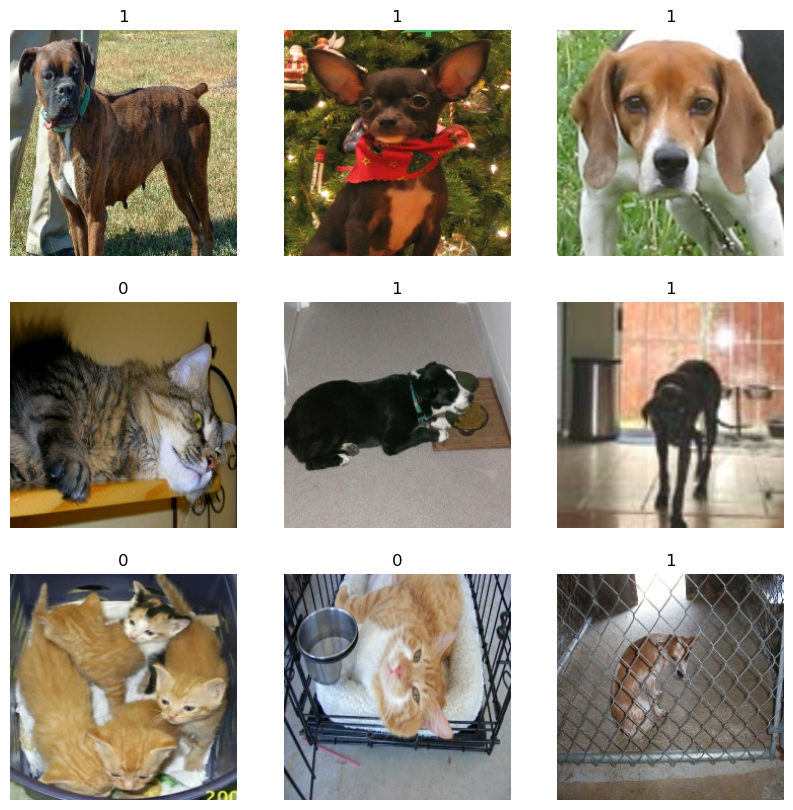

Batch of images shape: (224, 224, 3)
Batch of labels shape: (256,)


In [8]:
plt.figure(figsize = (10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(labels[i].numpy())
        plt.axis("off")
plt.show()

print("Batch of images shape:", image.shape)
print("Batch of labels shape:" ,labels.shape)

In [9]:
total = (int(len(validation_set)) + int(len(training_set)) + int(len(test_set))) * BATCH_SIZE
print(total)

23552


In [10]:
print('Number of train batches            : %d' % tf.data.experimental.cardinality(training_set))
print("Number of images in train set      :", len(training_set)*BATCH_SIZE)
print('Number of validation batches       : %d' % tf.data.experimental.cardinality(validation_set))
print("Number of images in validation set :", len(validation_set)*BATCH_SIZE)
print('Number of test batches             : %d' % tf.data.experimental.cardinality(test_set))
print("Number of images in test set       :", len(test_set)*BATCH_SIZE)

Number of train batches            : 73
Number of images in train set      : 18688
Number of validation batches       : 12
Number of images in validation set : 3072
Number of test batches             : 7
Number of images in test set       : 1792


In [33]:
print(training_set)
print(test_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [26]:
# import shutil

# test_set.save('test_set')
# shutil.make_archive('test_set', 'zip', 'test_set')

'/home/s2310144/workshop/Underspecification/DogsVsCats/test_set.zip'

# Modeling 

In [8]:
from tensorflow.keras.layers       import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics      import Precision, Recall, AUC
from tensorflow.keras.backend      import epsilon
from tensorflow.keras.initializers import GlorotUniform

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [9]:
# set a global seed
tf.random.set_seed(42)
initializer = GlorotUniform(seed = 42)

In [11]:
def add_classifier(base_model, initializer = initializer):
    x       = base_model.output
    x       = GlobalAveragePooling2D()(x)
    x       = Dropout(0.2)(x)
    x       = Dense(512,
                    activation         = 'relu',
                    kernel_initializer = initializer,
                    kernel_regularizer = l2(0.001))(x)
    x       = Dropout(0.4)(x)
    
    outputs = Dense(1,
                    activation         = 'sigmoid',
                    kernel_initializer = initializer,
                    kernel_regularizer = l2(0.001))(x)

    return outputs


def compile_and_train(model, train_dataset, val_dataset, epochs = 10):
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss      = 'binary_crossentropy',
        metrics   = ['accuracy',
                    Precision(name = 'precision'),
                    Recall(name    = 'recall'),
                    AUC(name       = 'auc'),
                    F1Score(name   = 'f1_score')
                    ]
    )

    history = model.fit(train_dataset,
                        validation_data = val_dataset,
                        batch_size      = 256,
                        epochs          = epochs
                       )
    return history

In [12]:
def plot_performance(model_history, model_name):
    plt.figure(figsize=(10,5))

    plt.subplot(2,3,1)
    plt.plot(model_history.history['accuracy'], label     = 'Training Accurary')
    plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuarcy')
    plt.legend()
    plt.title(f'{model_name} Accuracy')

    plt.subplot(2,3,2)
    plt.plot(model_history.history['loss'], label     = 'Training Loss')
    plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Loss')
    
    plt.subplot(2,3,3)
    plt.plot(model_history.history['precision'], label     = 'Training Precision')
    plt.plot(model_history.history['val_precision'], label = 'Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'{model_name} Precision')
    
    plt.subplot(2,3,4)
    plt.plot(model_history.history['recall'], label     = 'Training Recall')
    plt.plot(model_history.history['val_recall'], label = 'Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(f'{model_name} Recall')
    
    plt.subplot(2,3,5)
    plt.plot(model_history.history['auc'], label     = 'Training AUC')
    plt.plot(model_history.history['val_auc'], label = 'Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.title(f'{model_name} AUC')
    
    plt.subplot(2,3,6)
    plt.plot(model_history.history['f1_score'], label     = 'Training F1-Score')
    plt.plot(model_history.history['val_f1_score'], label = 'Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title(f'{model_name} F1-Score')
    
    plt.tight_layout()
    plt.show()

Epoch 1/10
73/73 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.9733 - precision: 0.9719 - recall: 0.9744 - auc: 0.9963 - f1_score: 0.9732

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


73/73 [==============================] - 75s 989ms/step - loss: 0.6262 - accuracy: 0.9733 - precision: 0.9719 - recall: 0.9744 - auc: 0.9963 - f1_score: 0.9732 - val_loss: 0.3676 - val_accuracy: 0.9881 - val_precision: 0.9862 - val_recall: 0.9903 - val_auc: 0.9988 - val_f1_score: 0.9883
Epoch 2/10
73/73 [==============================] - 70s 957ms/step - loss: 0.2593 - accuracy: 0.9879 - precision: 0.9870 - recall: 0.9885 - auc: 0.9990 - f1_score: 0.9878 - val_loss: 0.1817 - val_accuracy: 0.9885 - val_precision: 0.9910 - val_recall: 0.9861 - val_auc: 0.9989 - val_f1_score: 0.9885
Epoch 3/10
73/73 [==============================] - 69s 951ms/step - loss: 0.1422 - accuracy: 0.9875 - precision: 0.9863 - recall: 0.9886 - auc: 0.9988 - f1_score: 0.9874 - val_loss: 0.1112 - val_accuracy: 0.9874 - val_precision: 0.9842 - val_recall: 0.9910 - val_auc: 0.9990 - val_f1_score: 0.9876
Epoch 4/10
73/73 [==============================] - 70s 960ms/step - loss: 0.0977 - accuracy: 0.9862 - precision: 

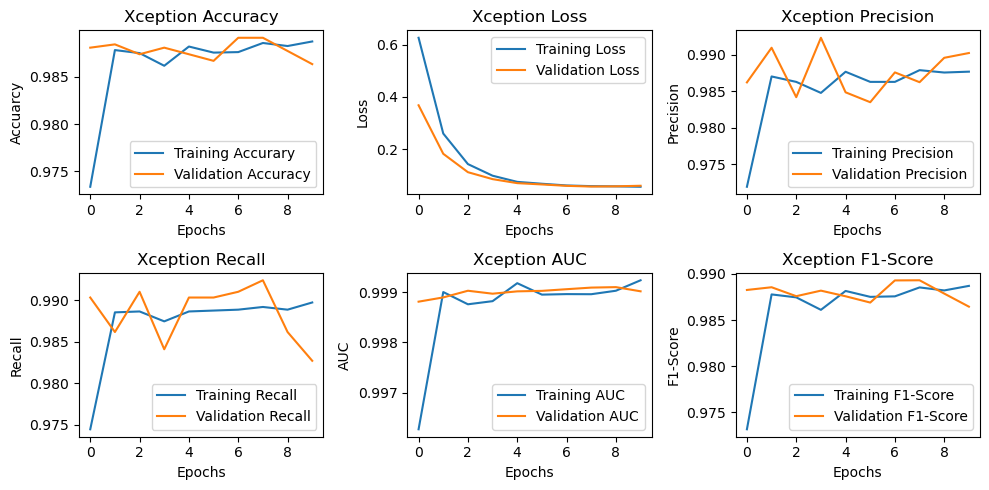

CPU times: user 7h 37min 38s, sys: 2min 35s, total: 7h 40min 14s
Wall time: 11min 46s


In [13]:
%%time
# base xception
base_xception           = tf.keras.applications.Xception(include_top = False,
                                                         weights     = 'imagenet',
                                                         input_shape = (224,224,3))
base_xception.trainable = False

xception_outputs        = add_classifier(base_xception)
xception                = tf.keras.Model(inputs  = base_xception.input,
                                         outputs = xception_outputs,
                                         name    = 'Xception_CvD')
xception_history        = compile_and_train(xception,
                                            training_set,
                                            validation_set)

plot_performance(xception_history, 'Xception')

In [14]:
train_acc_xception      = xception_history.history['accuracy'][-1]
val_acc_xception        = xception_history.history['val_accuracy'][-1]

_, test_acc_xception, _, _, _, _   = xception.evaluate(test_set)

if train_acc_xception > 0.95 and val_acc_xception > 0.95 and test_acc_xception > 0.95:
    xception.save('models/diff_extrcs/xception.h5')
    print('Model saved as xception.h5')

7/7 [==============================] - 6s 787ms/step - loss: 0.0606 - accuracy: 0.9872 - precision: 0.9935 - recall: 0.9817 - auc: 0.9992 - f1_score: 0.9875


/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as xception.h5


Epoch 1/10
73/73 [==============================] - 38s 467ms/step - loss: 0.8277 - accuracy: 0.9558 - precision: 0.9546 - recall: 0.9565 - auc: 0.9887 - f1_score: 0.9555 - val_loss: 0.6044 - val_accuracy: 0.9871 - val_precision: 0.9896 - val_recall: 0.9848 - val_auc: 0.9992 - val_f1_score: 0.9872
Epoch 2/10
73/73 [==============================] - 33s 448ms/step - loss: 0.5101 - accuracy: 0.9870 - precision: 0.9848 - recall: 0.9892 - auc: 0.9985 - f1_score: 0.9870 - val_loss: 0.4261 - val_accuracy: 0.9874 - val_precision: 0.9903 - val_recall: 0.9848 - val_auc: 0.9993 - val_f1_score: 0.9875
Epoch 3/10
73/73 [==============================] - 33s 447ms/step - loss: 0.3654 - accuracy: 0.9881 - precision: 0.9865 - recall: 0.9896 - auc: 0.9986 - f1_score: 0.9880 - val_loss: 0.3153 - val_accuracy: 0.9885 - val_precision: 0.9930 - val_recall: 0.9841 - val_auc: 0.9991 - val_f1_score: 0.9885
Epoch 4/10
73/73 [==============================] - 33s 450ms/step - loss: 0.2719 - accuracy: 0.9881 - 

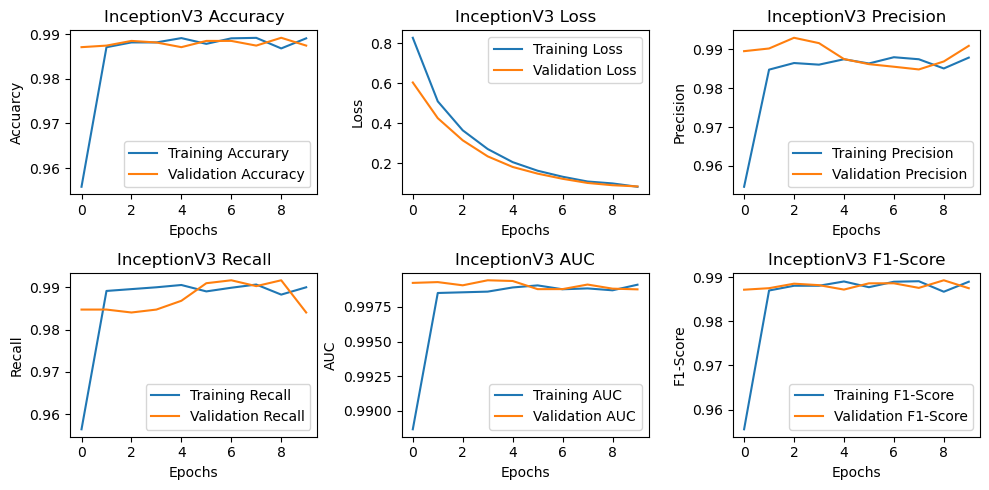

In [15]:
# base inception
base_inception              = tf.keras.applications.InceptionV3(include_top = False,
                                                   weights     = 'imagenet',
                                                   input_shape = (224,224,3))
base_inception.trainable    = False

inception_output            = add_classifier(base_inception)
inception                   = tf.keras.Model(inputs = base_inception.input,
                                         outputs = inception_output,
                                         name    = 'Inception-CvD')
inception_history           = compile_and_train(inception,
                                            training_set,
                                            validation_set)

train_acc_inception         = inception_history.history['accuracy'][-1]
val_acc_inception           = inception_history.history['val_accuracy'][-1]
_,test_acc_inception,_,_,_,_= inception.evaluate(test_set)

if train_acc_inception > 0.95 and val_acc_inception > 0.95 and test_acc_inception > 0.95:
    inception.save('models/diff_extrcs/inception.h5')
    print('Model saved as inception.h5')

plot_performance(inception_history, 'InceptionV3')

In [16]:
base_densenet           = tf.keras.applications.DenseNet121(include_top = False,
                                                            weights     = 'imagenet',
                                                            input_shape = (224,224,3))
base_densenet.trainable = False

Epoch 1/10
73/73 [==============================] - 75s 962ms/step - loss: 0.5401 - accuracy: 0.9460 - precision: 0.9436 - recall: 0.9478 - auc: 0.9896 - f1_score: 0.9457 - val_loss: 0.3237 - val_accuracy: 0.9818 - val_precision: 0.9827 - val_recall: 0.9813 - val_auc: 0.9983 - val_f1_score: 0.9820
Epoch 2/10
73/73 [==============================] - 67s 919ms/step - loss: 0.2855 - accuracy: 0.9819 - precision: 0.9818 - recall: 0.9818 - auc: 0.9983 - f1_score: 0.9818 - val_loss: 0.2487 - val_accuracy: 0.9832 - val_precision: 0.9895 - val_recall: 0.9771 - val_auc: 0.9989 - val_f1_score: 0.9833
Epoch 3/10
73/73 [==============================] - 67s 922ms/step - loss: 0.2243 - accuracy: 0.9830 - precision: 0.9825 - recall: 0.9832 - auc: 0.9985 - f1_score: 0.9828 - val_loss: 0.2039 - val_accuracy: 0.9815 - val_precision: 0.9915 - val_recall: 0.9716 - val_auc: 0.9991 - val_f1_score: 0.9815
Epoch 4/10
73/73 [==============================] - 66s 910ms/step - loss: 0.1828 - accuracy: 0.9844 - 

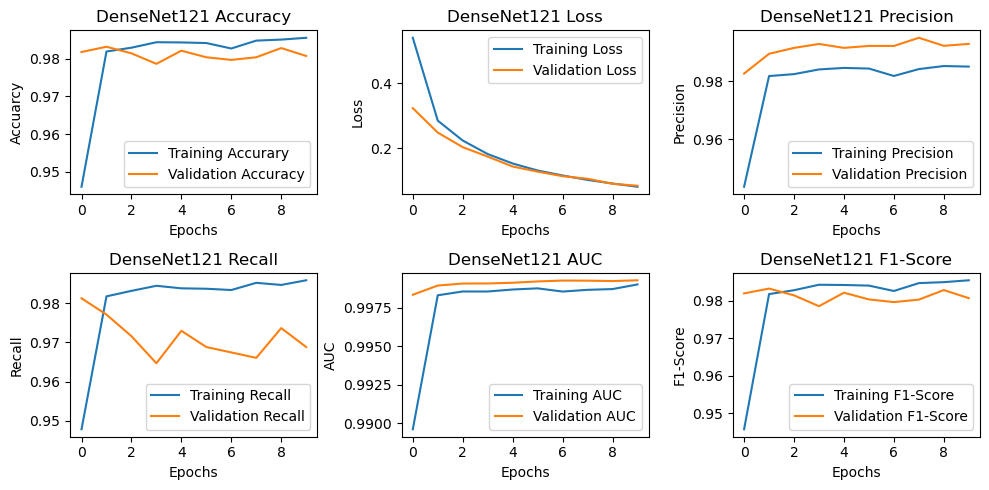

In [17]:
densenet_output         = add_classifier(base_densenet)
densenet                = tf.keras.Model(inputs = base_densenet.input,
                                outputs = densenet_output,
                                name    = 'Densenet-CvD')
densenet_history        = compile_and_train(densenet,
                                    training_set,
                                    validation_set)

train_acc_dense         = densenet_history.history['accuracy'][-1]
val_acc_dense           = densenet_history.history['val_accuracy'][-1]
_,test_acc_dense,_,_,_,_= densenet.evaluate(test_set)

if train_acc_dense > 0.95 and val_acc_dense > 0.95 and test_acc_dense > 0.95:
    densenet.save('models/diff_extrcs/densenet.h5')
    print('Model saved as densenet.h5')

plot_performance(densenet_history, 'DenseNet121')

Epoch 1/10
73/73 [==============================] - 56s 730ms/step - loss: 0.6118 - accuracy: 0.9711 - precision: 0.9711 - recall: 0.9706 - auc: 0.9954 - f1_score: 0.9709 - val_loss: 0.3908 - val_accuracy: 0.9846 - val_precision: 0.9868 - val_recall: 0.9827 - val_auc: 0.9985 - val_f1_score: 0.9847
Epoch 2/10
73/73 [==============================] - 52s 716ms/step - loss: 0.3051 - accuracy: 0.9867 - precision: 0.9868 - recall: 0.9864 - auc: 0.9988 - f1_score: 0.9866 - val_loss: 0.2393 - val_accuracy: 0.9864 - val_precision: 0.9855 - val_recall: 0.9875 - val_auc: 0.9986 - val_f1_score: 0.9865
Epoch 3/10
73/73 [==============================] - 53s 719ms/step - loss: 0.1958 - accuracy: 0.9875 - precision: 0.9874 - recall: 0.9874 - auc: 0.9989 - f1_score: 0.9874 - val_loss: 0.1694 - val_accuracy: 0.9860 - val_precision: 0.9916 - val_recall: 0.9806 - val_auc: 0.9989 - val_f1_score: 0.9861
Epoch 4/10
73/73 [==============================] - 52s 712ms/step - loss: 0.1430 - accuracy: 0.9880 - 

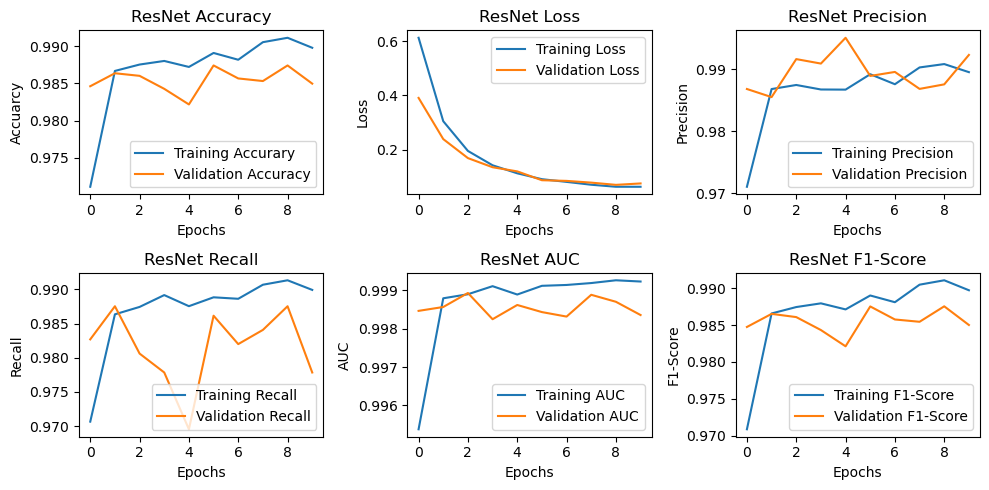

CPU times: user 5h 6min 8s, sys: 1min 10s, total: 5h 7min 19s
Wall time: 8min 52s


In [18]:
%%time
base_resnet           = tf.keras.applications.ResNet50V2(include_top = False,
                                                     weights = 'imagenet',
                                                     input_shape = (224,224,3))
base_resnet.trainable = False

resnet_output         = add_classifier(base_resnet)
resnet                = tf.keras.Model(inputs   = base_resnet.input,
                                        outputs = resnet_output,
                                        name    = 'ResNet-CvD')
resnet_history        = compile_and_train(resnet,
                                    training_set,
                                    validation_set)

train_acc_res         = resnet_history.history['accuracy'][-1]
val_acc_res           = resnet_history.history['val_accuracy'][-1]
_,test_acc_res,_,_,_,_= resnet.evaluate(test_set)

if train_acc_res > 0.95 and val_acc_res > 0.95 and test_acc_res > 0.95:
    resnet.save('models/diff_extrcs/resnet.h5')
    print('Model saved as resnet.h5')

plot_performance(resnet_history, 'ResNet')

In [109]:
# ////////////////// Train with Different Optimizers //////////////////////////////////////////

In [20]:
def train_with_diff_optimizers(model, train_dataset, val_dataset, optimizer, epochs = 15):
    model.compile(
        optimizer = optimizer,
        loss      = "binary_crossentropy",
        metrics   = [
            "accuracy",
            Precision(name = "precision"),
            Recall(name    = "recall"),
            AUC(name       = "auc"),
            F1Score(name   = "f1_score")
        ]
    )

    print(f"Training model with {type(optimizer).__name__} optimizer...")
    
    history = model.fit(train_dataset,
                       epochs          = epochs,
                       validation_data = val_dataset)
    
    return history

Training model with Adam optimizer...
Epoch 1/15
73/73 [==============================] - 74s 952ms/step - loss: 0.5401 - accuracy: 0.9460 - precision: 0.9436 - recall: 0.9478 - auc: 0.9896 - f1_score: 0.9457 - val_loss: 0.3237 - val_accuracy: 0.9818 - val_precision: 0.9827 - val_recall: 0.9813 - val_auc: 0.9983 - val_f1_score: 0.9820
Epoch 2/15
73/73 [==============================] - 67s 925ms/step - loss: 0.2855 - accuracy: 0.9819 - precision: 0.9818 - recall: 0.9818 - auc: 0.9983 - f1_score: 0.9818 - val_loss: 0.2487 - val_accuracy: 0.9832 - val_precision: 0.9895 - val_recall: 0.9771 - val_auc: 0.9989 - val_f1_score: 0.9833
Epoch 3/15
73/73 [==============================] - 68s 926ms/step - loss: 0.2243 - accuracy: 0.9830 - precision: 0.9825 - recall: 0.9832 - auc: 0.9985 - f1_score: 0.9828 - val_loss: 0.2039 - val_accuracy: 0.9815 - val_precision: 0.9915 - val_recall: 0.9716 - val_auc: 0.9991 - val_f1_score: 0.9815
Epoch 4/15
73/73 [==============================] - 67s 915ms/ste

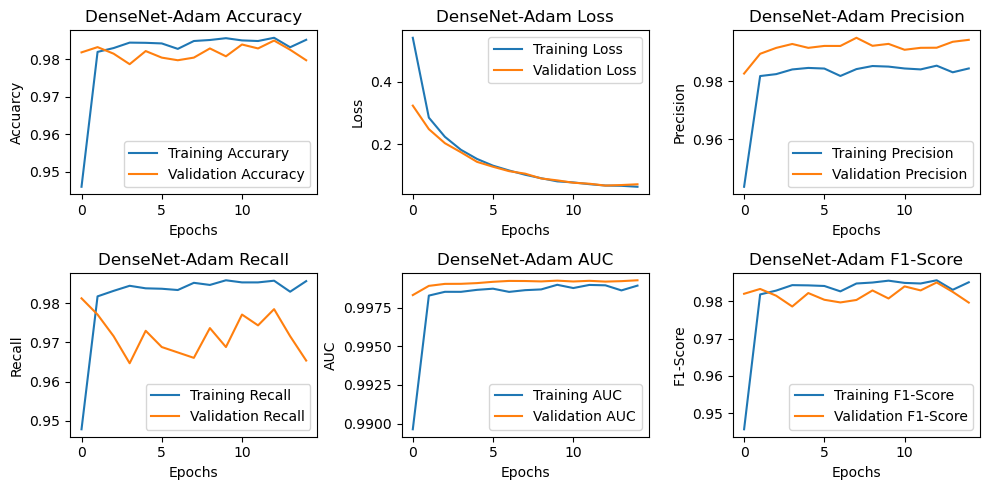

In [21]:
densenet_adam    = tf.keras.Model(inputs    = base_densenet.input,
                                    outputs = add_classifier(base_densenet),
                                    name    = "DenseNet-Adam")

adam_history     = train_with_diff_optimizers(densenet_adam,
                                          training_set,
                                          validation_set,
                                          optimizer = tf.keras.optimizers.Adam()
                                         )

train_acc_adam = adam_history.history["accuracy"][-1]
val_acc_adam   = adam_history.history["val_accuracy"][-1]
_, test_acc_adam, _, _, _, _  = densenet_adam.evaluate(test_set)

if train_acc_adam > 0.95 and val_acc_adam > 0.95 and test_acc_adam > 0.95:
    densenet_adam.save("models/diff_opts/densenet_adam.h5")
    print("Model saved as densenet_adam.h5")

plot_performance(adam_history, "DenseNet-Adam")

Training model with SGD optimizer...
Epoch 1/15
73/73 [==============================] - 74s 947ms/step - loss: 0.9153 - accuracy: 0.9109 - precision: 0.9143 - recall: 0.9052 - auc: 0.9714 - f1_score: 0.9098 - val_loss: 0.7709 - val_accuracy: 0.9720 - val_precision: 0.9583 - val_recall: 0.9875 - val_auc: 0.9961 - val_f1_score: 0.9727
Epoch 2/15
73/73 [==============================] - 67s 916ms/step - loss: 0.7905 - accuracy: 0.9622 - precision: 0.9577 - recall: 0.9664 - auc: 0.9933 - f1_score: 0.9620 - val_loss: 0.7512 - val_accuracy: 0.9748 - val_precision: 0.9667 - val_recall: 0.9841 - val_auc: 0.9970 - val_f1_score: 0.9753
Epoch 3/15
73/73 [==============================] - 67s 920ms/step - loss: 0.7671 - accuracy: 0.9699 - precision: 0.9659 - recall: 0.9736 - auc: 0.9955 - f1_score: 0.9697 - val_loss: 0.7433 - val_accuracy: 0.9762 - val_precision: 0.9674 - val_recall: 0.9861 - val_auc: 0.9974 - val_f1_score: 0.9767
Epoch 4/15
73/73 [==============================] - 66s 911ms/step

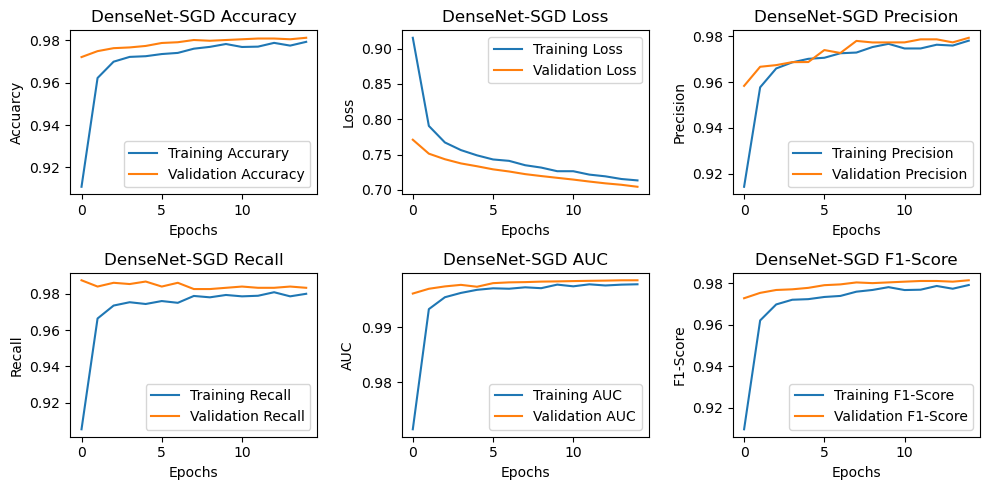

CPU times: user 10h 28min 59s, sys: 2min 40s, total: 10h 31min 40s
Wall time: 16min 56s


In [22]:
%%time
densenet_sgd  = tf.keras.Model(inputs   = base_densenet.input,
                                outputs = add_classifier(base_densenet),
                                name    = "DenseNet-SGD"
                              )

sgd_history   = train_with_diff_optimizers(densenet_sgd,
                                              training_set,
                                              validation_set,
                                              optimizer = tf.keras.optimizers.SGD()
                                         )

train_acc_sgd = sgd_history.history["accuracy"][-1]
val_acc_sgd   = sgd_history.history["val_accuracy"][-1]
_,test_acc_sgd,_,_,_,_= densenet_sgd.evaluate(test_set)

if train_acc_sgd > 0.95 and val_acc_sgd > 0.95 and test_acc_sgd > 0.95:
    densenet_sgd.save("models/diff_opts/densenet_sgd.h5")
    print("Model saved as densenet_sgd.h5")

plot_performance(sgd_history, "DenseNet-SGD")

Training model with RMSprop optimizer...
Epoch 1/15
73/73 [==============================] - 73s 940ms/step - loss: 0.7198 - accuracy: 0.9512 - precision: 0.9469 - recall: 0.9553 - auc: 0.9816 - f1_score: 0.9510 - val_loss: 0.4341 - val_accuracy: 0.9829 - val_precision: 0.9834 - val_recall: 0.9827 - val_auc: 0.9987 - val_f1_score: 0.9830
Epoch 2/15
73/73 [==============================] - 68s 931ms/step - loss: 0.3583 - accuracy: 0.9764 - precision: 0.9750 - recall: 0.9775 - auc: 0.9971 - f1_score: 0.9763 - val_loss: 0.2691 - val_accuracy: 0.9787 - val_precision: 0.9657 - val_recall: 0.9931 - val_auc: 0.9983 - val_f1_score: 0.9792
Epoch 3/15
73/73 [==============================] - 68s 930ms/step - loss: 0.2220 - accuracy: 0.9798 - precision: 0.9791 - recall: 0.9802 - auc: 0.9977 - f1_score: 0.9796 - val_loss: 0.1688 - val_accuracy: 0.9822 - val_precision: 0.9794 - val_recall: 0.9855 - val_auc: 0.9991 - val_f1_score: 0.9824
Epoch 4/15
73/73 [==============================] - 67s 913ms/

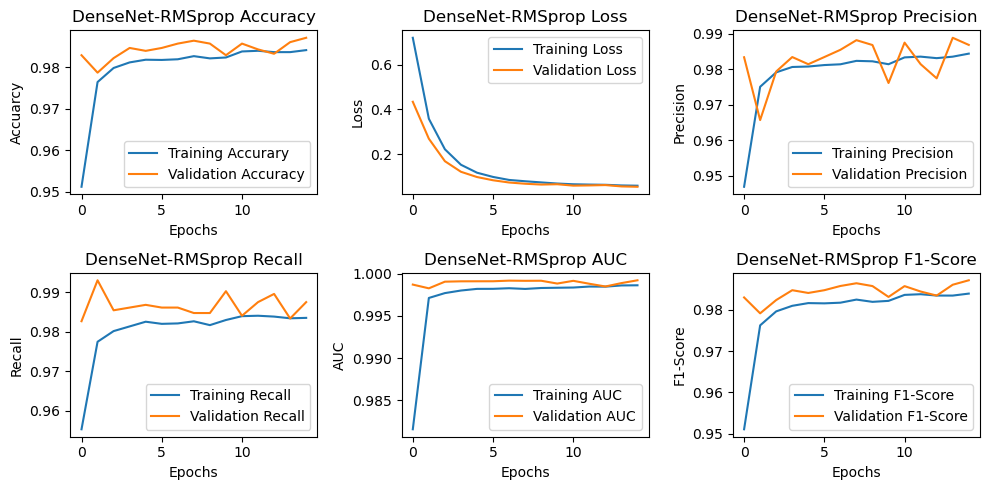

CPU times: user 10h 29min 58s, sys: 2min 34s, total: 10h 32min 33s
Wall time: 17min 2s


In [23]:
%%time
densenet_rmsp  = tf.keras.Model(inputs  = base_densenet.input,
                                  outputs = add_classifier(base_densenet),
                                  name    = "DenseNet-RMSprop")

rmsp_history   = train_with_diff_optimizers(densenet_rmsp,
                                              training_set,
                                              validation_set,
                                              optimizer = tf.keras.optimizers.RMSprop()
                                         )

train_acc_rmsp = rmsp_history.history["accuracy"][-1]
val_acc_rmsp   = rmsp_history.history["val_accuracy"][-1]
_,test_acc_rmsp,_,_,_,_= densenet_rmsp.evaluate(test_set)

if train_acc_rmsp > 0.95 and val_acc_rmsp > 0.95 and test_acc_rmsp > 0.95:
    densenet_rmsp.save("models/diff_opts/densenet_rmsp.h5")
    print("Model saved as densenet_rmsp.h5")

plot_performance(rmsp_history, "DenseNet-RMSprop")

Training model with Nadam optimizer...
Epoch 1/15
73/73 [==============================] - 73s 935ms/step - loss: 0.5387 - accuracy: 0.9551 - precision: 0.9523 - recall: 0.9574 - auc: 0.9906 - f1_score: 0.9548 - val_loss: 0.3176 - val_accuracy: 0.9815 - val_precision: 0.9780 - val_recall: 0.9855 - val_auc: 0.9985 - val_f1_score: 0.9817
Epoch 2/15
73/73 [==============================] - 67s 923ms/step - loss: 0.2785 - accuracy: 0.9822 - precision: 0.9821 - recall: 0.9819 - auc: 0.9983 - f1_score: 0.9820 - val_loss: 0.2368 - val_accuracy: 0.9832 - val_precision: 0.9814 - val_recall: 0.9855 - val_auc: 0.9990 - val_f1_score: 0.9834
Epoch 3/15
73/73 [==============================] - 67s 925ms/step - loss: 0.2149 - accuracy: 0.9838 - precision: 0.9835 - recall: 0.9838 - auc: 0.9985 - f1_score: 0.9836 - val_loss: 0.1889 - val_accuracy: 0.9843 - val_precision: 0.9808 - val_recall: 0.9882 - val_auc: 0.9991 - val_f1_score: 0.9845
Epoch 4/15
73/73 [==============================] - 67s 918ms/st

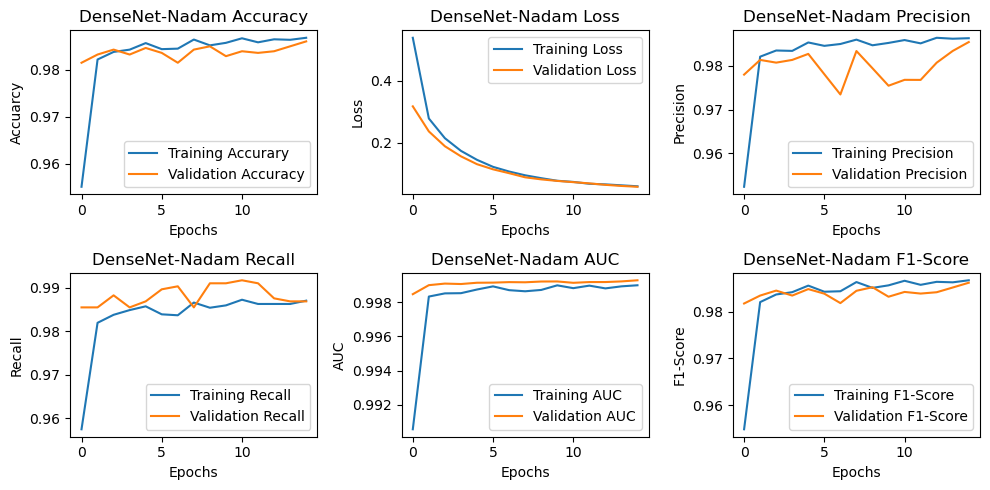

CPU times: user 10h 29min 58s, sys: 2min 39s, total: 10h 32min 38s
Wall time: 17min 1s


In [24]:
%%time
densenet_nadam    = tf.keras.Model(inputs  = base_densenet.input,
                                  outputs = add_classifier(base_densenet),
                                  name    = "DenseNet-Nadam")

nadam_history     = train_with_diff_optimizers(densenet_nadam,
                                              training_set,
                                              validation_set,
                                              optimizer = tf.keras.optimizers.Nadam()
                                         )

train_acc_nadam = nadam_history.history["accuracy"][-1]
val_acc_nadam   = nadam_history.history["val_accuracy"][-1]
_,test_acc_nadam,_,_,_,_= densenet_nadam.evaluate(test_set)

if train_acc_nadam > 0.95 and val_acc_nadam > 0.95 and test_acc_nadam > 0.95:
    densenet_nadam.save("models/diff_opts/densenet_nadam.h5")
    print("Model saved as densenet_nadam.h5")

plot_performance(nadam_history, "DenseNet-Nadam")